# N-Body Exomoon Stability Map Tutorial

In this tutorial, we'll go over a slightly more advanced application of the `NbodyQuadTree` class in ``astroQTpy``. Here we'll investigate the stability of a hypothetical moon orbiting a long-period massive planet as a function of the moon's semi-major axis $a_{moon}$ and the planet's eccentricity $e_{planet}$.

First, we need to define what we mean by "stable." Gravitational perturbations from the host star and planet over many orbits can culminate in the moon escaping the graviational influence of the planet, defined by the planet's Hill sphere. Once the moon has escaped the Hill sphere, we can no longer consider it a moon, thus we would consider the system unstable. While the Hill sphere defines the outer limit of the moon's orbital stability, we can define the *inner* stability limit at the radius of the planet (i.e., the system is unstable if the moon collides with the planet). Note we could also consider the Roche limit here, the distance at which tidal forces between the moon and planet would destroy the moon. However, calculating the Roche limit requires making assumptions about the interiors of the moon and planet, and typically works out to be on the order of a few planetary radii. Therefore, the keep things simple we'll just assume the inner limit is the planet's radius.

Let's define a function to determine the Hill radius for a given system. The Hill radius is defined as:

$$ r_{Hill} = a_{planet} \bigg(\frac{m_*}{3 m_{planet}}\bigg)^{1/3} $$

where $a_{planet}$ and $m_{planet}$ denote the semi-major axis and mass of the planet and $m_*$ is the mass of the host star.

In [1]:
def calc_hill_radius(mass_primary, mass_secondary, sma_secondary):
    
    return sma_secondary * (mass_primary / (3 * mass_secondary))**(1./3)

In this tutorial we'll consider a real exoplanet system, modeling the central star and outermost giant planet in the HIP 41378 system (following [Harada et al. 2023](https://ui.adsabs.harvard.edu/abs/2023arXiv230314294H/abstract)). The following system parameters were derived by [Santerne et al. 2019](https://ui.adsabs.harvard.edu/abs/2019arXiv191107355S/abstract).

In [2]:
from astropy import constants

# HIP 41378
M_star = 1.16 * constants.M_sun.value
a_star = 1.37 * constants.au.value

# HIP 41378 f
M_planet = 12 * constants.M_earth.value
R_planet = 9.2 * constants.R_earth.value

Now let's make up a moon to put in orbit around the planet. As a plausible upper limit, we'll go with a moon with the same satellite-to-planet mass ratio as the Moon-Earth system ($m_{Moon} / m_{Earth} \approx 0.0123$). This gives us a moon about 15% as massive as the Earth.

In [3]:
import numpy as np

# hypothetical moon
M_moon = 0.0123 * M_planet   # Moon-Earth mass ratio
print("M_moon: {:.3f} Earth masses".format(M_moon / constants.M_earth.value))

M_moon: 0.148 Earth masses


Now we just need the inner and outer stability limits before we can proceed. In units of AU, we have:

In [4]:
hill_radius = calc_hill_radius(M_planet, M_star, a_star)   # mks
print("Hill radius: {:.3f} AU".format(hill_radius / constants.au.value))
print("Planet radius: {:.5f} AU".format(R_planet / constants.au.value))

Hill radius: 0.030 AU
Planet radius: 0.00039 AU


We're now ready to proceed as we did in the more simple N-body tutorial. We'll define a function that returns the outcome of an N-body simulation, create an instance of `NbodyQuadTree` in ``astrQTpy``, then run the quadtree. Since this type of hierarchical N-body model is more computationally expensive (because the moon's orbital timescale is much smaller than that of the planet), we'll take advantage of ``astrQTpy``'s multiprocessing capabilities. Note that in order to get this to work in a Python notebook, we must define this function externally, then import it. We've written the function `exomoon_simulation` in a separate Python file (`nbody_sim_functions.py`), but it is copied below so that you can see what's going under the hood.

In [5]:
from nbody_sim_functions import exomoon_simulation

Our function looks like this:

```python

    import numpy as np
    import rebound
    import astropy.constants as constants


    def exomoon_simulation(params):
        """Run a hierarchical N-body simulation with one planet and one moon around the planet. 
        
        Args:
            params (tuple): eccentricity of planet and semi-major axis of moon (in fraction of Hill Radius)
        
        """
        
        # unpack params
        ecc_planet, a_moon = params
        
        # constants
        MEARTH_TO_MSUN = constants.M_earth.value / constants.M_sun.value
        DAY_TO_YEAR = 1. / 365.25
        MIN_DIST = 0.00039   # AU (planet radius)
        MAX_DIST = 0.030     # AU (Hill radius)
        
        # fixed params
        m_star = 1.16                                   # stellar mass
        mass_moon = 0.148 * MEARTH_TO_MSUN              # moon mass 
        mass_planet = 12. * MEARTH_TO_MSUN              # planet mass
        period_planet = 542.08 * DAY_TO_YEAR * 2*np.pi  # planet orbital period
        
        # hyperparams
        sim_time = 1e2  # run for 100 years
        N_outputs = 50
        
        # random mean anomaly for moon
        ma_moon = np.random.uniform(0, 2*np.pi)
        
        # set up simulation
        sim = rebound.Simulation()
        sim.integrator = "ias15"
        
        sim.add(m=m_star, hash="star")  # add star
        sim.add(m=mass_planet, P=period_planet, e=ecc_planet, M=0., inc=np.pi/2, hash="planet")  # add planet around star
        sim.add(m=mass_moon, a=a_moon*MAX_DIST, e=0., M=ma_moon, inc=np.pi/2,
                primary=sim.particles[-1], hash="moon")  # add moon around planet
        
        sim.dt = 0.05 * sim.particles[-1].P  # first timestep is 5% of moon's orbital period
        sim.move_to_com()
        
        sim.exit_min_distance = MIN_DIST  # catch encounters

        # run simulation
        timescale = sim_time * (2 * np.pi)  # units where G=1
        ps = sim.particles  # an array of pointers that will update as the simulation runs
        times = np.linspace(0, timescale, N_outputs)

        try:
            for time in times:
                sim.integrate(time)
                dp_moon = ps["planet"] - ps["moon"]  # calculate the component-wise difference between moon and planet
                dist_sq_moon = dp_moon.x*dp_moon.x + dp_moon.y*dp_moon.y + dp_moon.z*dp_moon.z
                if dist_sq_moon > MAX_DIST**2:
                    return 0.  # moon escaped Hill sphere: unstable
                
        except rebound.Encounter:
            return 0.  # close encounter: unstable
        
        return 1.  # stable
```

This function takes as input a tuple array of $(e_{planet}, a_{moon})$ and returns either a zero or one depending on the outcome of the simulation. If the moon escapes the planet's Hill sphere or a collision occurs, a 0 is returned. Otherwise a 1 is returned.

Let's test it out!

In [6]:
exomoon_simulation((0.3, 0.4))

0.0

The return value of 0 indicates that the initial conditions (0.3, 0.4) result in an unstable moon orbit.

Now let's use a quadtree to explore a range of parameters! As in other tutorials, we need to define the range of $e$ and $a$ that we wish to explore, then create a new instance of `NbodyQuadTree`.

In [7]:
x_min, x_max = 0, 0.5      # planet eccentricity
y_min, y_max = 0.25, 0.55  # moon semi-major axis (in Hill radii)

In [8]:
import astroqtpy.quadtree as qt

nbody_tree = qt.NbodyQuadTree(x_min, x_max, y_min, y_max, exomoon_simulation,
                              split_threshold=0.2,
                              N_points=12,
                              N_proc=4,
                              filename_points = './tutorial_outputs/nbody_moon_points.txt',
                              filename_nodes = './tutorial_outputs/nbody_moon_nodes.txt'
                              )

Let's run it!

In [9]:
nbody_tree.run_quadtree()

Attempting to load previous results...
   No previous results found, starting new...
DONE! :)


This took about 9 minutes to run on my laptop.

Now let's plot the quadtree map!

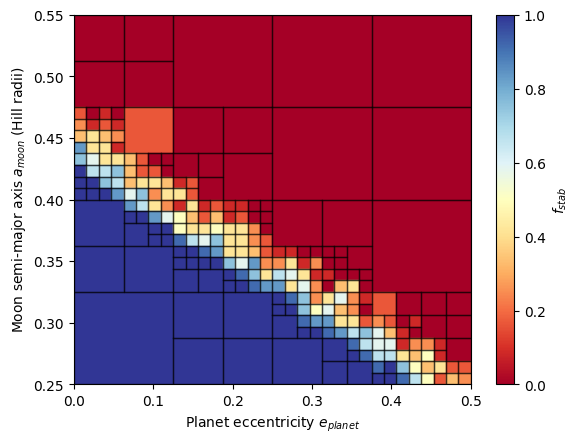

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.set_xlabel('Planet eccentricity $e_{planet}$')
ax.set_ylabel('Moon semi-major axis $a_{moon}$ (Hill radii)')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

cm = nbody_tree.draw_tree(ax, vmin=0, vmax=1, cmap='RdYlBu')
plt.colorbar(cm, ax=ax, label='$f_{stab}$')

plt.show(); 